# omfit_classes v. tokamaker read_eqdsk

This notebook compares a few geometry parameters extracted from the same eqdsk file with `omfit_classes.omfit_eqdsk.OMFITgeqdsk` and an expanded version of `TokaMaker.read_eqdsk` which is the `read_eqdsk_extended` function in `read_eqdsk_extended.py`. This calculates flux surface averaging and calculates $\text{Vol}(psi)$ and $d\text{Vol}/d\psi (\psi)$ using algorithms similar to those in OMFIT.

`omfit_classes` requires an older version of `scipy` and `numpy` so to use this notebook you have to run the following (if you dont use `uv` just leave that out):
```
uv pip install "scipy==1.13.1"
```

and 
```
uv pip install "numpy<2.0"
```

When you're done and you want to upgrade `scipy` and `numpy` back to the latest version, run this:
```
uv pip install --upgrade scipy numpy
```




F. Sheehan 2026-02-16


In [1]:
from OpenFUSIONToolkit.TokaMaker.util import read_eqdsk
import matplotlib.pyplot as plt
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
import numpy as np
from read_eqdsk_extended import read_eqdsk_extended

In [ ]:
# Load OMFIT data into dict 
g_om = OMFITgeqdsk('iter_hmode.eqdsk')
g_om.load()

g_om['fluxSurfaces'].load()

# fill OMFIT dict
om = {
    'psi_axis': g_om['SIMAG'],
    'psi_lcfs': g_om['SIBRY'],
    'R0': g_om['RCENTR'],
    'B0': g_om['BCENTR'],
    'Ip': g_om['CURRENT'],

    'q_prof': g_om['QPSI'],

    'R_avg': g_om['fluxSurfaces']['avg']['R'],
    'R_inv_avg': g_om['fluxSurfaces']['avg']['1/R'],

    'vol': g_om['fluxSurfaces']['geo']['vol'],
    'vol_lcfs': g_om['fluxSurfaces']['geo']['vol'][-1],
    'vpr': g_om['fluxSurfaces']['avg']['vp'],  # dV/dψ in OMFIT

    'psi_N': g_om['fluxSurfaces']['geo']['psin'],
    'psi': g_om['fluxSurfaces']['geo']['psi']
    

}

In [ ]:
# Load TokaMaker data into dict 
tm_data = read_eqdsk_extended('iter_hmode.eqdsk')

# Populate TokaMaker dictionary with same structure as OMFIT
tm = {
    'psi_axis': tm_data['psimag'],
    'psi_lcfs': tm_data['psibry'],
    'R0': tm_data['rcentr'],
    'B0': tm_data['bcentr'],
    'Ip': tm_data['ip'],

    'q_prof': tm_data['qpsi'],

    'R_avg': tm_data['R_avg'],
    'R_inv_avg': tm_data['R_inv_avg'],

    'vol': tm_data['vol'],
    'vol_lcfs': tm_data['vol_lcfs'],
    'vpr': tm_data['vpr'],

    'psi_N': tm_data['psi_n'],
    'psi': tm_data['psi']
    

}

psi_grid_tm = np.linspace(tm['psi_axis'], tm['psi_lcfs'], len(tm['q_prof']))
temp = (psi_grid_tm - tm['psi_axis']) / (tm['psi_lcfs'] - tm['psi_axis'])

print(f"\nAvailable keys in TokaMaker data: {list(tm_data.keys())}")



Available keys in TokaMaker data: ['case', 'nr', 'nz', 'rdim', 'zdim', 'rcentr', 'rleft', 'zmid', 'raxis', 'zaxis', 'psimag', 'psibry', 'bcentr', 'ip', 'fpol', 'pres', 'ffprim', 'pprime', 'psirz', 'qpsi', 'nbbs', 'nlim', 'rzout', 'rzlim', 'psi_n', 'psi', 'vol', 'vol_lcfs', 'vpr', 'R_avg', 'R_inv_avg']


In [14]:
# Scalar comparison table
print(f"\n{'Parameter':<20} {'OMFIT':<15} {'read_eqdsk_extended':<30} {'Diff %':<15}")
print("-"*75)

# Basic parameters
params = [
    ('psi_axis (Wb/rad)', om['psi_axis'], tm['psi_axis']),
    ('psi_lcfs (Wb/rad)', om['psi_lcfs'], tm['psi_lcfs']),
    ('R0 (m)', om['R0'], tm['R0']),
    ('B0 (T)', om['B0'], tm['B0']),
    ('Ip (A)', om['Ip'], tm['Ip']),
    ('q_axis', om['q_prof'][0], tm['q_prof'][0]),
    ('q_lcfs', om['q_prof'][-1], tm['q_prof'][-1]),
    ('Volume LCFS (m³)', om['vol_lcfs'], tm['vol_lcfs'])
]


for name, val_omfit, val_tm in params:
    if val_tm is not None:
        diff_pct = 100 * (val_omfit - val_tm) / val_omfit if val_omfit != 0 else 0
        print(f"{name:<20} {val_omfit:<20.6g} {val_tm:<20.6g} {diff_pct:>14.4f}%")
    else:
        print(f"{name:<20} {val_omfit:<20.6g} {'N/A':<20} {'N/A':<15}")




Parameter            OMFIT           read_eqdsk_extended            Diff %         
---------------------------------------------------------------------------
psi_axis (Wb/rad)    -19.2763             -19.2763                    -0.0000%
psi_lcfs (Wb/rad)    -10.0177             -10.0177                    -0.0000%
R0 (m)               6.22621              6.22621                      0.0000%
B0 (T)               5.36281              5.36281                      0.0000%
Ip (A)               1.3e+07              1.3e+07                      0.0000%
q_axis               1.37993              1.37993                      0.0000%
q_lcfs               4.20657              4.20657                      0.0000%
Volume LCFS (m³)     809.791              797.491                      1.5190%


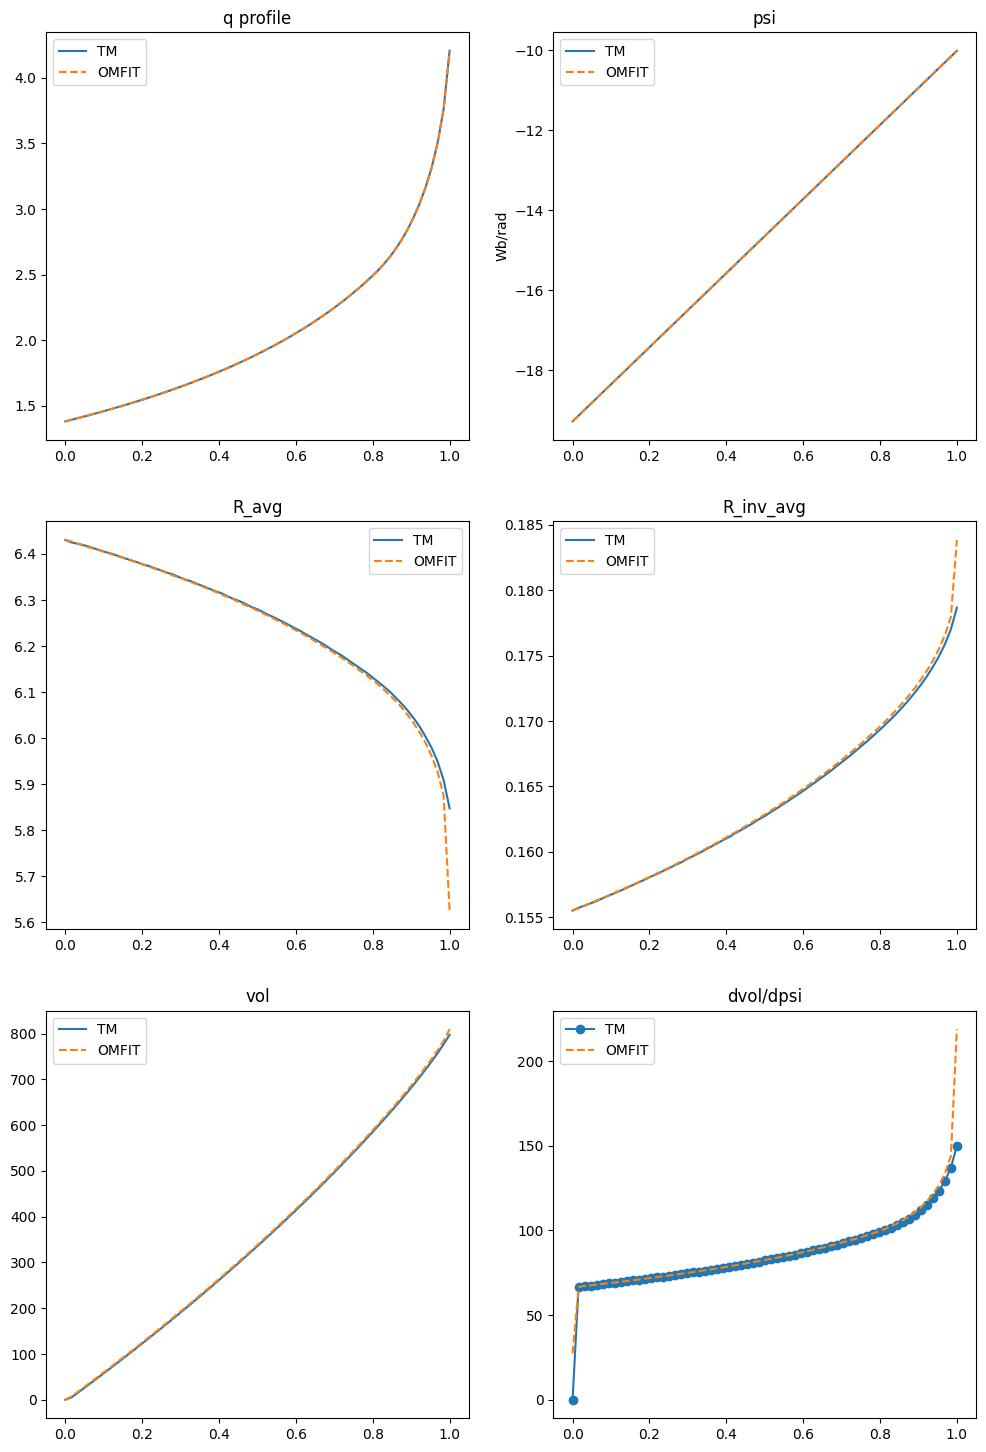

In [9]:
# Profile comparison plot
fig, axes = plt.subplots(3,2,figsize=(12,18))

ax00 = axes[0,0]
ax01 = axes[0,1]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax20 = axes[2,0]
ax21 = axes[2,1]

ax00.set_title('q profile')
ax00.plot(tm['psi_N'], tm['q_prof'], label='TM')
ax00.plot(om['psi_N'], om['q_prof'], '--', label='OMFIT')
ax00.legend()

ax01.set_title('psi')
ax01.plot(tm['psi_N'], tm['psi'], label='TM')
ax01.plot(om['psi_N'], om['psi'], '--', label='OMFIT')
ax01.set_ylabel('Wb/rad')
ax01.legend()

ax10.set_title('R_avg')
ax10.plot(tm['psi_N'], tm['R_avg'], label='TM')
ax10.plot(om['psi_N'], om['R_avg'], '--', label='OMFIT')
ax10.legend()

ax11.set_title('R_inv_avg')
ax11.plot(tm['psi_N'], tm['R_inv_avg'], label='TM')
ax11.plot(om['psi_N'], om['R_inv_avg'], '--', label='OMFIT')
ax11.legend()

ax20.set_title('vol')
ax20.plot(tm['psi_N'], tm['vol'], label='TM')
ax20.plot(om['psi_N'], om['vol'], '--', label='OMFIT')
ax20.legend()

ax21.set_title('dvol/dpsi')
ax21.plot(tm['psi_N'], tm['vpr'], label='TM', marker='o')
ax21.plot(om['psi_N'], om['vpr'], '--', label='OMFIT')
ax21.legend()

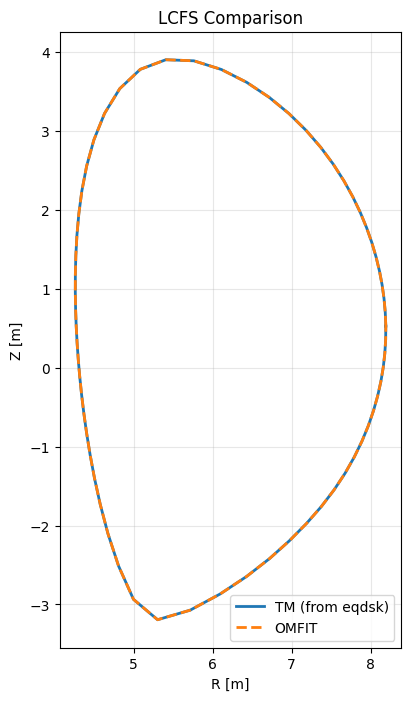

In [ ]:
# LCFS boundary comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect('equal')
ax.set_title('LCFS Comparison')
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')


# TokaMaker boundary from eqdsk file
tm_R = tm_data['rzout'][:, 0]
tm_Z = tm_data['rzout'][:, 1]
ax.plot(tm_R, tm_Z, '-', linewidth=2, label='TM (from eqdsk)')


# OMFIT boundary
omfit_R = g_om['RBBBS']
omfit_Z = g_om['ZBBBS']
ax.plot(omfit_R, omfit_Z, '--', linewidth=2, label='OMFIT')
ax.legend()
ax.grid(True, alpha=0.3)